<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="https://raw.githubusercontent.com/DataForScience/Networks/master/data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0" width=150px> </div>
    <div style="float: left; margin-left: 10px;"> <h1>Edge Weight and Network structure</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
from collections import Counter
from pprint import pprint
from itertools import combinations

import pandas as pd
import numpy as np
import sqlite3

import matplotlib
import matplotlib.pyplot as plt 

import networkx as nx

import tqdm as tq
from tqdm import tqdm

import watermark

%load_ext watermark
%matplotlib inline

We start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 21.3.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

Git hash: 58d07878bc88b565bc1569df8f5a33c4ae028a46

pandas    : 1.1.3
matplotlib: 3.3.2
networkx  : 2.5
json      : 2.0.9
watermark : 2.1.0
sqlite3   : 2.6.0
numpy     : 1.19.2
tqdm      : 4.62.0



Load default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Toy Network

Let us write out a simple toy network

In [4]:
G = nx.Graph()
G.add_edges_from([
    (0, 1),
    (0, 2),
    (0, 3),
    (0, 4),
    (0, 5),
    (3, 2),
    (3, 4),
    (1, 6),
    (2, 6),
    (3, 6),
    (4, 6),
    (5, 6),
])

pos = {
    0:(-1, 0),
    1:(0, 1),
    2:(0, .5),
    3:(0, 0),
    4:(0, -.5),
    5:(0, -1),
    6:(1, 0),
}

node_colors = np.array(colors)[[0, 3, 1, 2, 1, 3, 0]]

And make a quick visualization

{0: Text(-1, 0, '0'),
 1: Text(0, 1, '1'),
 2: Text(0, 0.5, '2'),
 3: Text(0, 0, '3'),
 4: Text(0, -0.5, '4'),
 5: Text(0, -1, '5'),
 6: Text(1, 0, '6')}

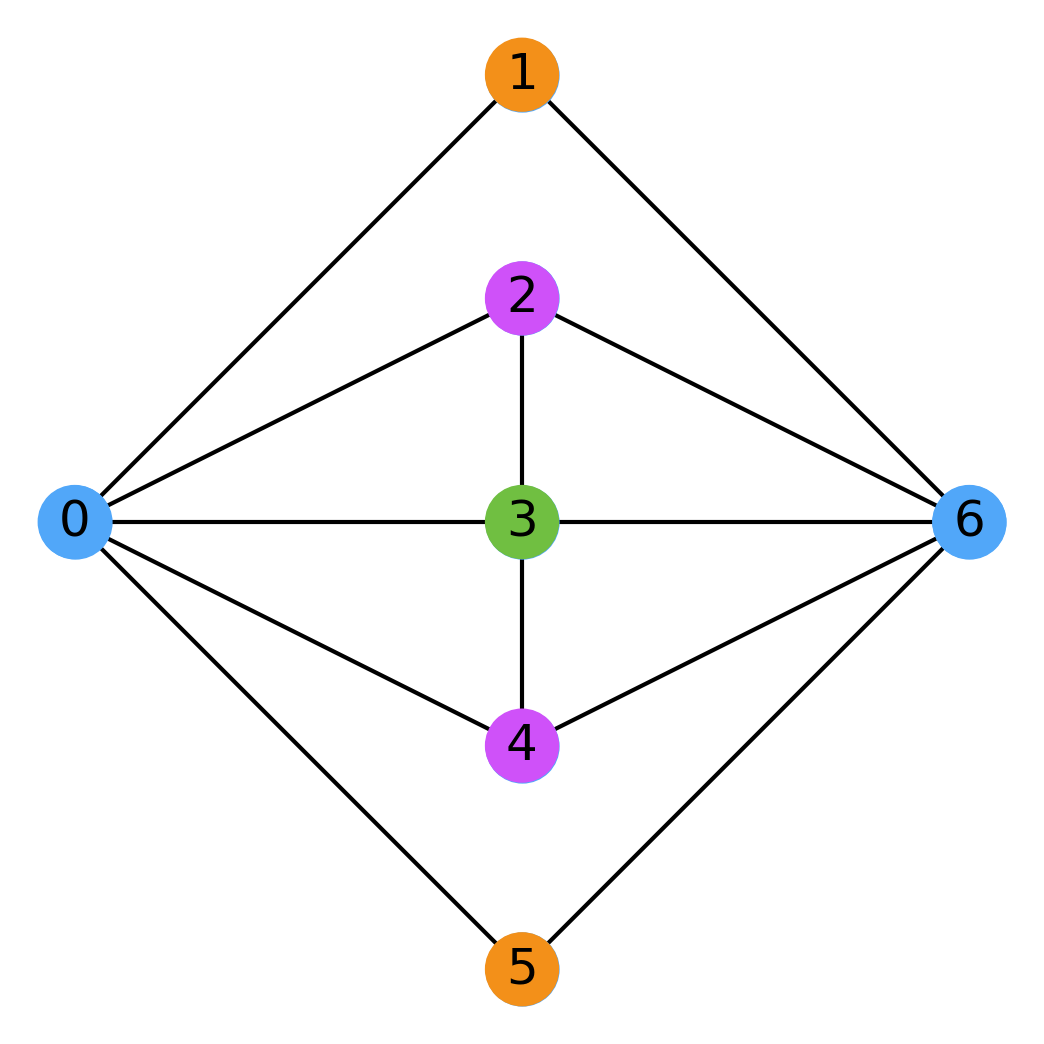

In [5]:
fig, ax = plt.subplots(1, figsize=(4, 4))
ax.set_aspect(1)
nx.draw(G, pos=pos, node_color=None)
nx.draw_networkx_nodes(G, pos=pos, node_color=node_colors)
nx.draw_networkx_labels(G, pos=pos)

# Neighborhood Overlap

In the network above, it's clear that several nodes have similar properties. 0 and 6 have the same set of neighbors, as do 5 and 1, 4 and 2, etc. The only node that is truly unique is node number 3.

We formalize this intuition using the overlap:
$$ O_{i,j}=\frac{\mathrm{common~neighbors}_{i, j}}{\mathrm{total~neighbors}_{i, j}}$$

which we implement in Python as

In [6]:
def get_overlap(G, full=False):
    overlap = {}
    NN = {}
    
    # Consider all pairs or only existing edges 
    # depending on the value of full
    edges = (combinations(G.nodes(), 2) 
             if full else G.edges())
    
    # For each pair of nodes we're considering
    for node_i, node_j in edges:
        # Get neighborhoods making sure we don't repeatedly 
        # evaluate the same neighborhood
        if node_i not in NN:
            NN[node_i] = set(nx.neighbors(G, node_i))

        if node_j not in NN:
            NN[node_j] = set(nx.neighbors(G, node_j))
        
        # Compute the overlap excluding the nodes themselves
        common_neighbors = (NN[node_i] & NN[node_j]) - set([node_i, node_j])
        total_neighbors = (NN[node_i] | NN[node_j])  - set([node_i, node_j])
        
        if len(total_neighbors) > 0:
            overlap[(node_i, node_j)] = len(common_neighbors)/len(total_neighbors)
        else:
            overlap[(node_i, node_j)] = 0
    
    return overlap

For this simple network we have:

In [7]:
pd.DataFrame.from_dict(get_overlap(G), orient='index').round(2)

,0
"(0, 1)",0.00
"(0, 2)",0.20
"(0, 3)",0.40
"(0, 4)",0.20
"(0, 5)",0.00
"(1, 6)",0.00
"(2, 3)",0.67
"(2, 6)",0.20
"(3, 4)",0.67
"(3, 6)",0.40


where we easily find that the nodes with the highest neighborhood overlap are 2 and 3 and 3 and 4, both with 2/3, while many other pairs of nodes (like 0 and 1) have no common neighbors at all.

# Facebook-like Social Network

In [8]:
data = pd.read_csv('data/OF_one-mode_weightedmsg_sum.txt', sep=' ', header=None)

In [9]:
G = nx.Graph()
G.add_weighted_edges_from(data.values)

The network has 

In [10]:
N = G.number_of_nodes()
N

897

In [11]:
E = G.number_of_edges()
E

71380

In [12]:
nx.is_connected(G)

True

We compute the overlap along all edges

In [13]:
overlap = get_overlap(G)

And plot its distribution

In [14]:
overlap_dist = pd.DataFrame(Counter(np.round(list(overlap.values()), 2)).items())
overlap_dist[1] /= E
overlap_dist.columns = ['Overlap', 'P(Overlap)']
overlap_dist.sort_values('Overlap', inplace=True)

Text(0.5, 0, '$Overlap$')

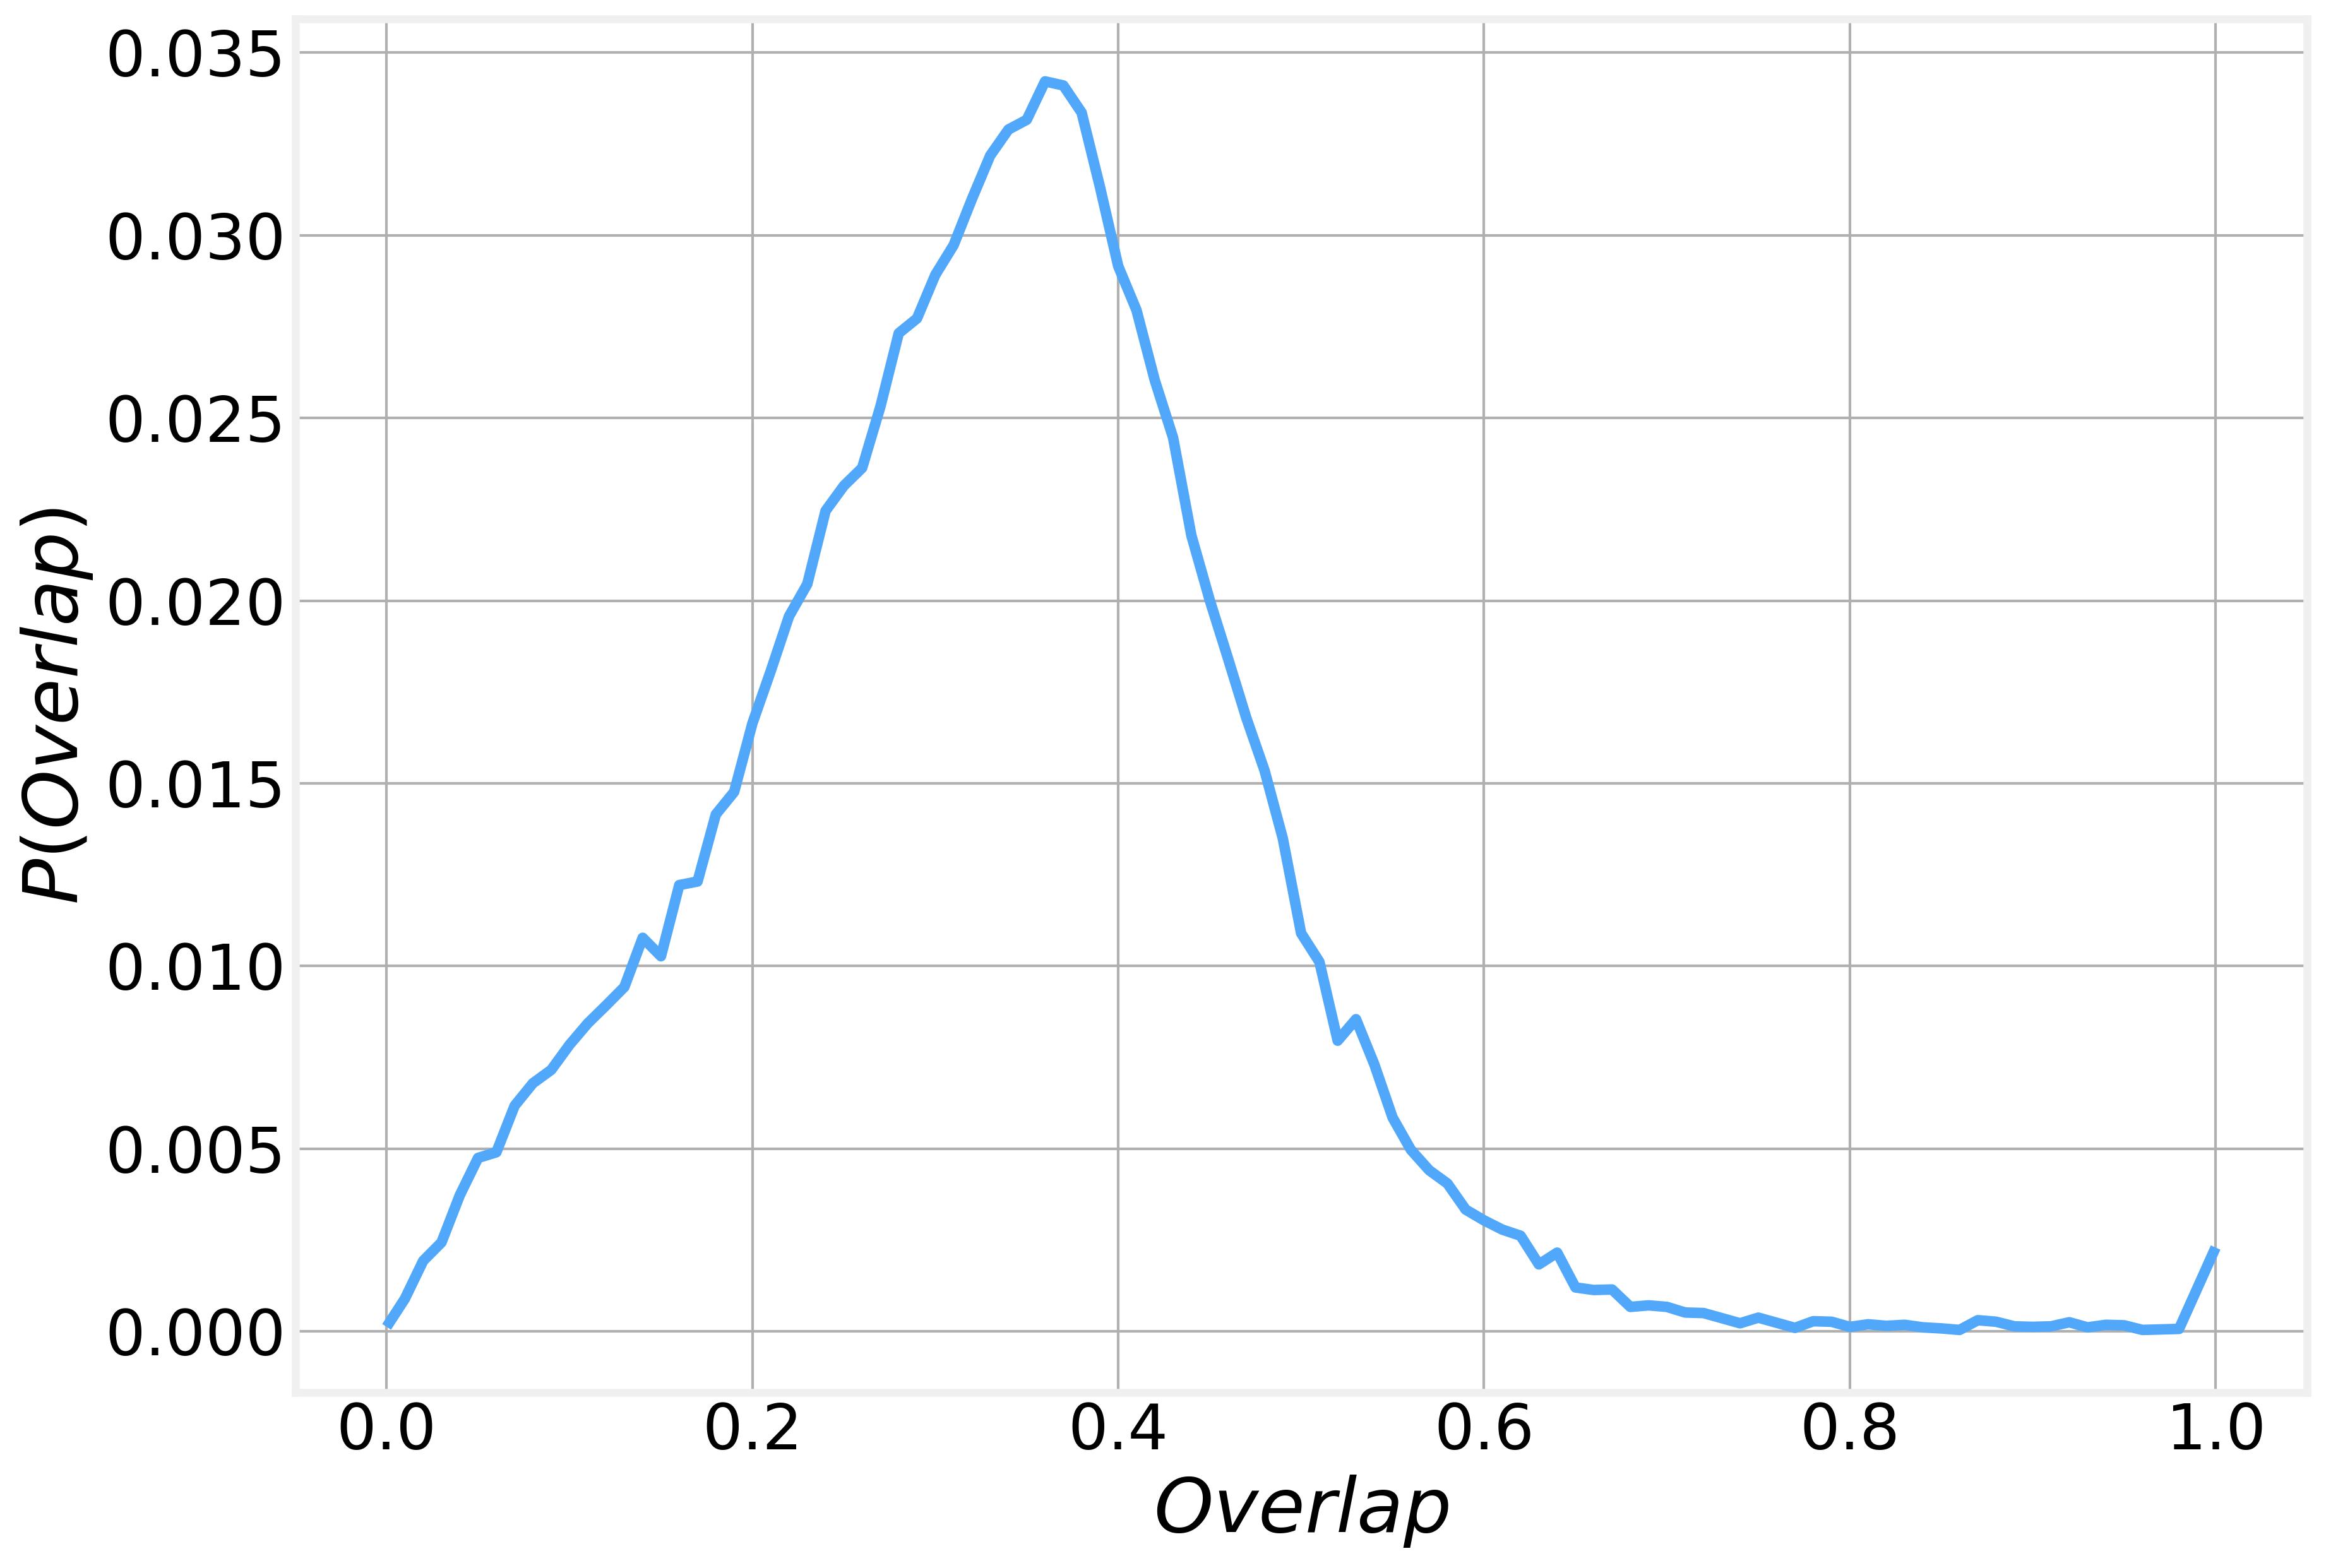

In [15]:
ax = overlap_dist.plot(x='Overlap', y='P(Overlap)', legend=None)
ax.set_ylabel(r'$P\left(Overlap\right)$')
ax.set_xlabel(r'$Overlap$')

As we can see, most edges have relatively low overlaps (<0.4) with just a few edges connecting nodes with high degrees of overlaps (~1.0). On the other hand, the weight distribution is significantly broad tailed:

In [16]:
weight_distribution = pd.DataFrame(Counter([w for i, j, w in G.edges(data="weight")]).items())
weight_distribution.sort_values(0, inplace=True)
weight_distribution[1] /= E
weight_distribution.columns = ['w', 'P(w)']

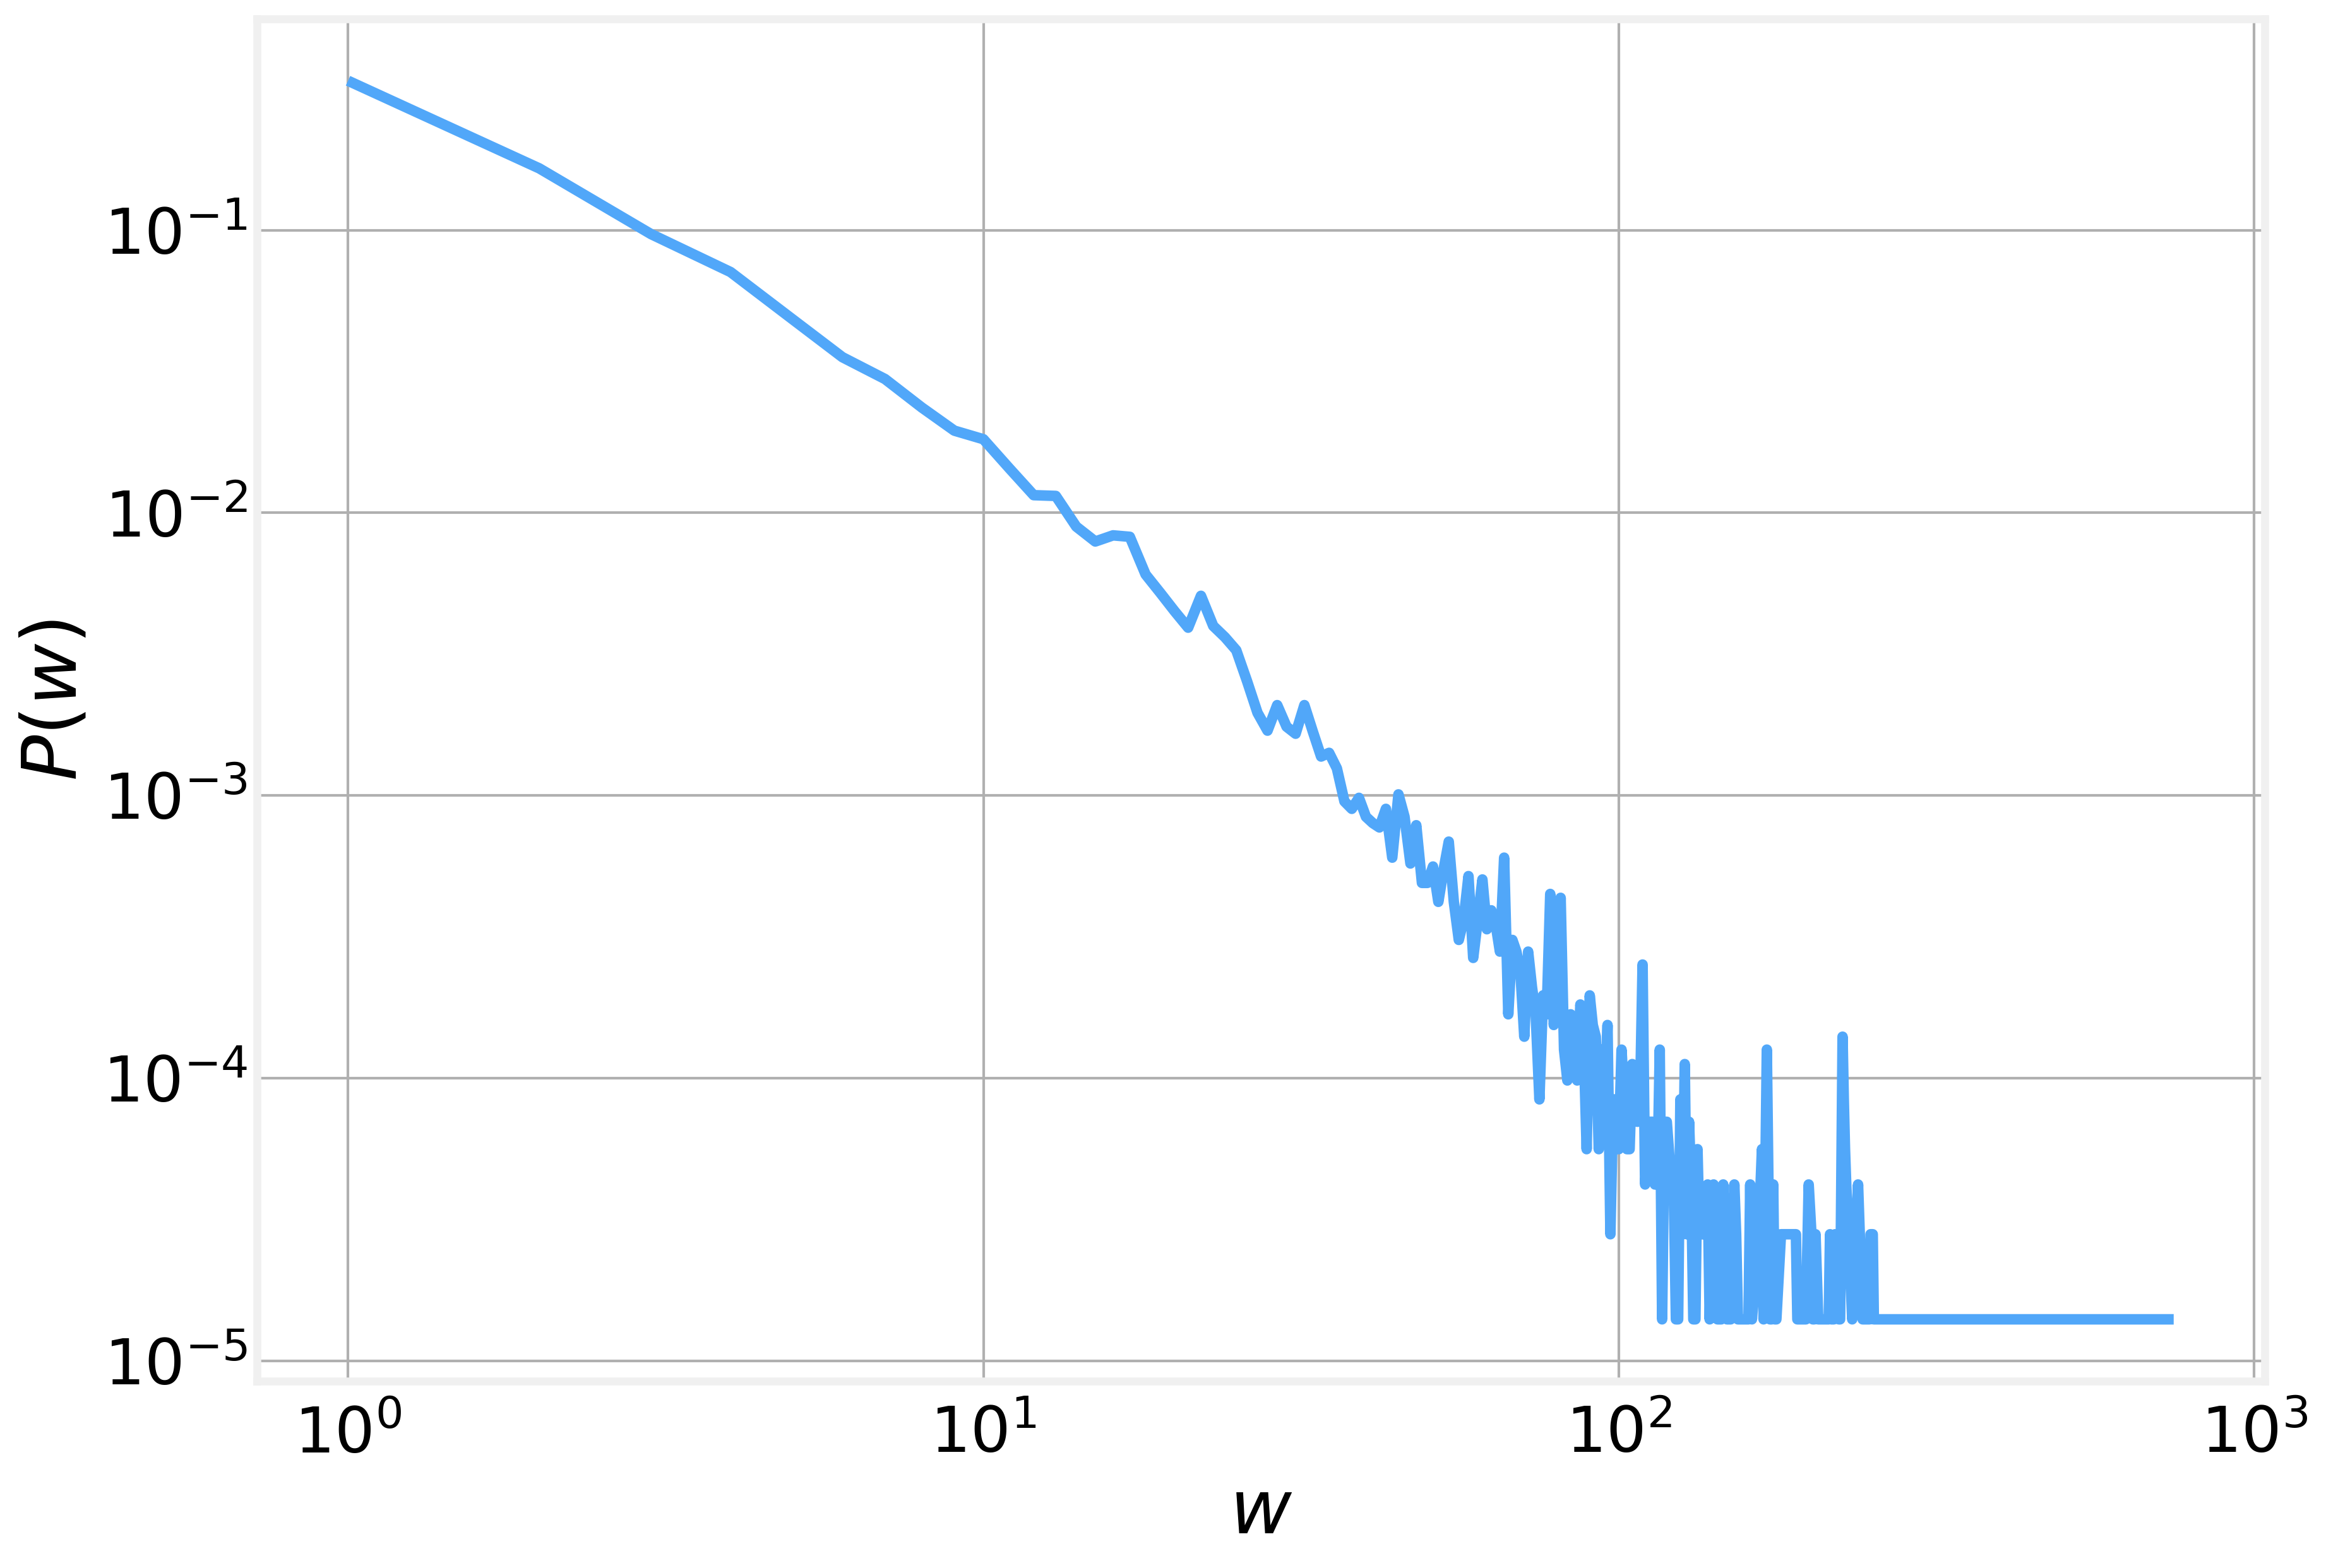

In [17]:
ax = weight_distribution.plot(x='w', y='P(w)', legend=None)
ax.set_ylabel(r'$P\left(w\right)$')
ax.set_xlabel(r'$w$')
ax.set_xscale('log')
ax.set_yscale('log')
[label.set_y(-0.01) for label in ax.xaxis.get_majorticklabels()];

Despite this difference in distribution, there is an impressive and important correlation between these two quantities. In particular, edges with higher weights connect nodes with higher degree of overlap.

In [18]:
overlap_weight = {}

for node_i, node_j, weight in G.edges(data="weight"):
    weight = np.power(2, int(np.log2(weight+1)))
    
    if weight not in overlap_weight:
        overlap_weight[weight] = []
        
    overlap_weight[weight].append(overlap[(node_i, node_j)])
    
for weight in overlap_weight:
    overlap_weight[weight] = (weight, 
                              np.mean(overlap_weight[weight]), 
                               np.std(overlap_weight[weight]))
    
overlap_weight = pd.DataFrame(overlap_weight.values())
overlap_weight.sort_values(0, inplace=True)

Plot the overlap as a function of the weight

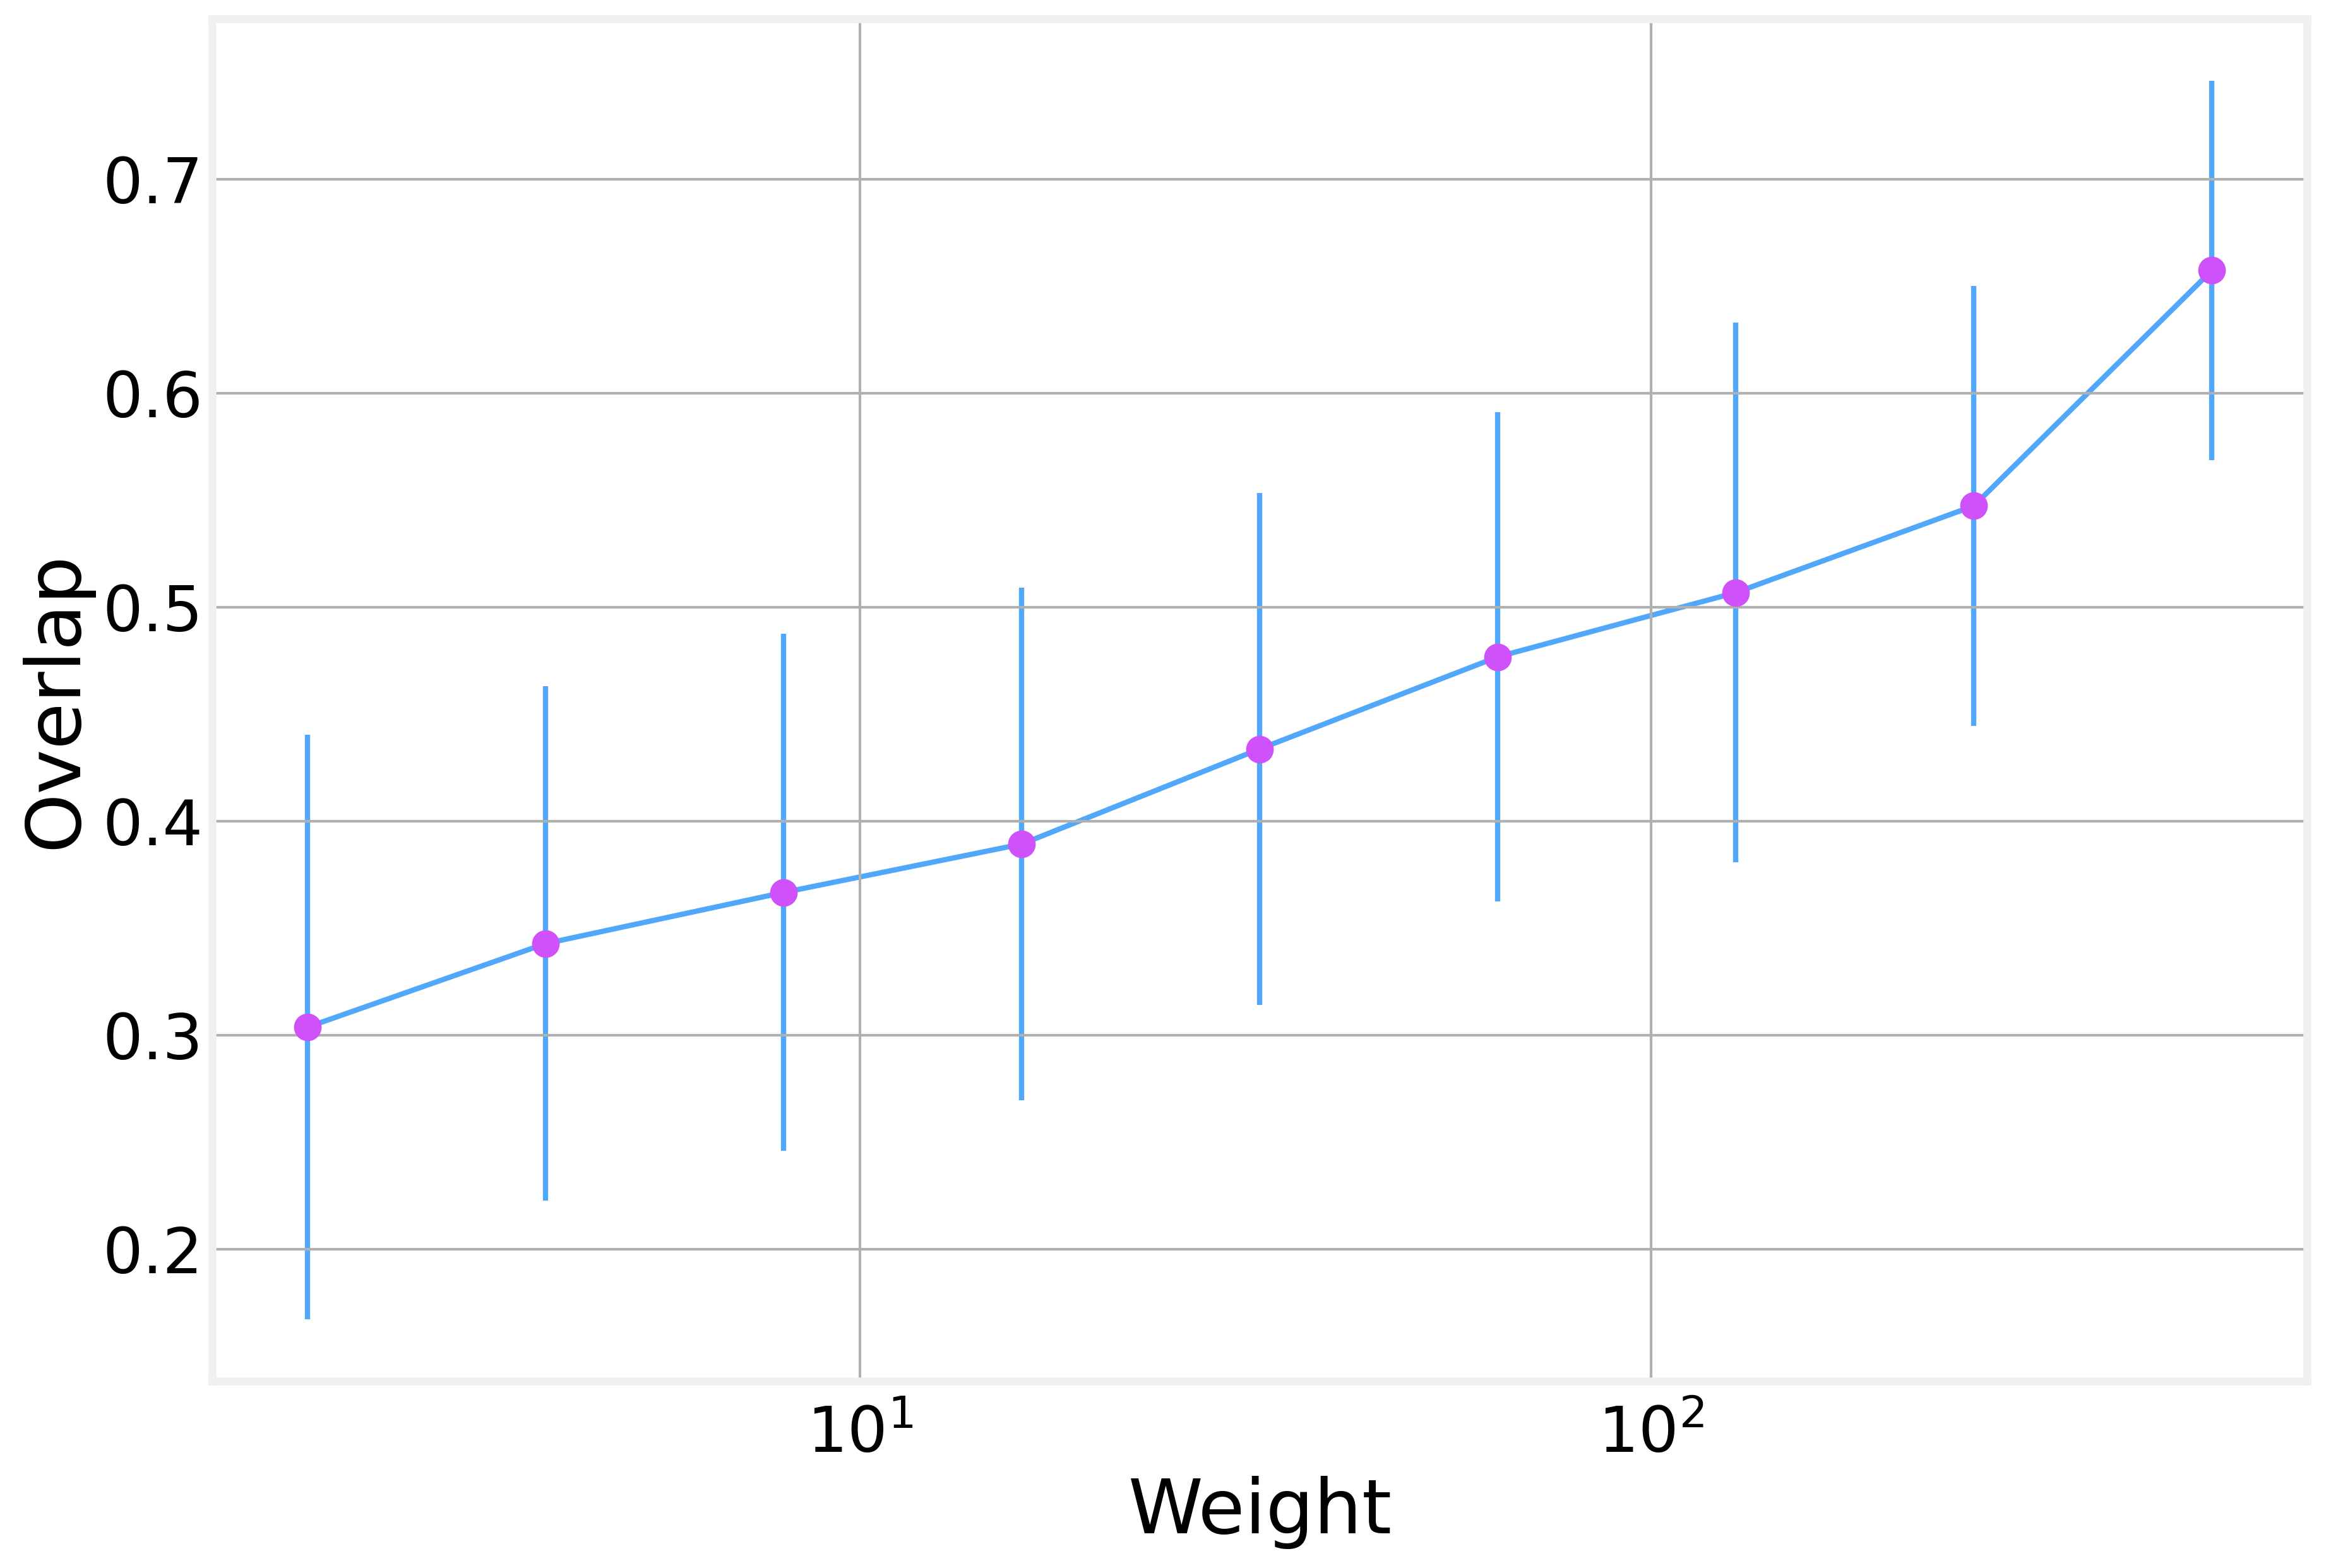

In [19]:
ax = overlap_weight.plot(x=0, y=1, yerr=2, legend=False, zorder=-1, lw=2)
overlap_weight.plot.scatter(x=0, y=1, color=colors[1], s=100, ax=ax, legend=False, zorder=2)
ax.set_xlabel('Weight')
ax.set_ylabel('Overlap')
ax.set_xscale('log')
[label.set_y(-0.01) for label in ax.xaxis.get_majorticklabels()];

Illustrating a clear increase of the degree of overlap as the edge weight increases.

<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>